# SARIMAX (seasonal autoregressive integrated moving average with exogenous regressors) Model

## Import data, handle missing values, create a clean dataframe

In [22]:
import pandas as pd
import numpy as np
# import seaborn as sns
from math import floor, sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

ic = pd.read_excel("D:\DS\Mine\Corona\I22-01.xlsx", index_col=0, parse_dates=[0]) # Iran Corona
ic['new_deaths_smoothed'] = ic['new_deaths_smoothed'].fillna(method='bfill')
ic['total_vaccinations_f'] = ic['total_vaccinations'].interpolate(method='linear').fillna(0)
ic['stringency_index_f'] = ic['stringency_index'].fillna(method="ffill")
icf = ic.loc[ : , ['total_cases', 'new_cases', 'new_cases_smoothed',
                   'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_vaccinations_f', 'stringency_index_f']]
icf = icf.asfreq(None)
pd.options.display.float_format = '{:,.2f}'.format
# pd.set_option('display.max_rows', 2000)
icf

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_vaccinations_f,stringency_index_f
date,,,,,,,,
2020-02-19,2,2,NaN,2,2,1.71,0.00,0.00
2020-02-20,5,3,NaN,2,0,1.71,0.00,2.78
2020-02-21,18,13,NaN,4,2,1.71,0.00,2.78
2020-02-22,28,10,NaN,5,1,1.71,0.00,11.11
2020-02-23,43,15,NaN,8,3,1.71,0.00,11.11
...,...,...,...,...,...,...,...,...
2021-12-28,6188857,2128,"1,867.86",131474,40,43.86,"116,210,697.00",61.57
2021-12-29,6190762,1905,"1,839.57",131527,53,45.14,"116,210,697.00",61.57
2021-12-30,6192698,1936,"1,840.14",131572,45,44.29,"116,210,697.00",61.57


## Defining constants, spliting train and test

In [23]:
length = icf.shape[0]                #number of records
train_len = floor(length * 0.95)     #of records are going to be used for training
print('Out of', length, 'samples,', train_len, 'samples were devoted to training section and the rest (i.e.',
      length - train_len, 'samples) to test section.')
prl = 28   #4 weeks                                    #prediction lendth: number of days to predict

icn = icf.loc[:,'new_deaths_smoothed']
xd = icn.values
xr = xd[:train_len]
xs = xd[train_len:train_len+prl]
xsp = []

Out of 683 samples, 648 samples were devoted to training section and the rest (i.e. 35 samples) to test section.


## Models

### Model 1: Auto ARIMA (Seasonal)

In [24]:
# The following line will make it possible to zoom and pan on graphs:
%matplotlib notebook

<IPython.core.display.Javascript object>


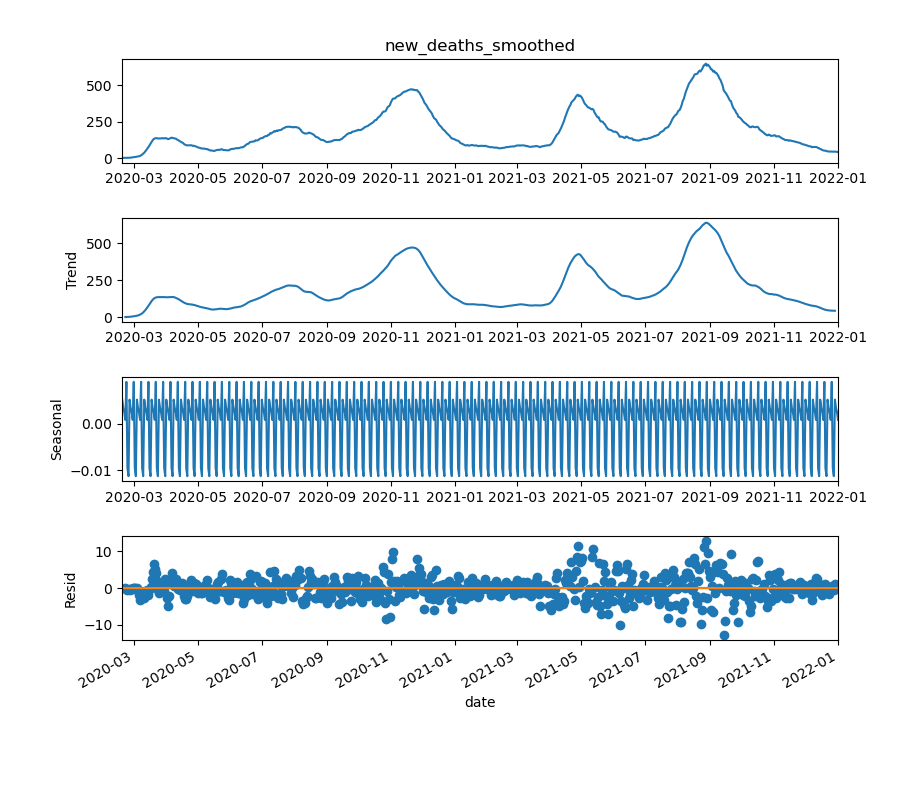

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(icf['new_deaths_smoothed'])
res.plot();
res.seasonal.plot(figsize=(9, 8));

In [45]:
res.seasonal.head(15)

date
2020-02-19    0.01
2020-02-20    0.00
2020-02-21    0.00
2020-02-22    0.00
2020-02-23    0.01
2020-02-24   -0.01
2020-02-25   -0.01
2020-02-26    0.01
2020-02-27    0.00
2020-02-28    0.00
2020-02-29    0.00
2020-03-01    0.01
2020-03-02   -0.01
2020-03-03   -0.01
2020-03-04    0.01
Freq: D, Name: seasonal, dtype: float64

The seasonality period extracted by seasonal_decompose is 7 days.

In [27]:
seasonality_period = 7
# weeks_per_year = 365 // seasonality_period  #Floor division
# print('There are approximately', weeks_per_year, 'weeks per year.')

In [7]:
# pip install pmdarima # if you don't have pmdarima

In [46]:
from pmdarima import auto_arima
aa = auto_arima(xr, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, # m=seasonality_period,
                         start_P=0, # seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4174.909, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8276.037, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7427.235, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8973.377, Time=0.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3728.765, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3730.637, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3730.650, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3994.955, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3770.017, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3700.811, Time=0.61 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=3686.382, Time=0.42 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3731.9

In [49]:
aa.fit(xr, maxiter=500)

ARIMA(order=(4, 0, 3), scoring_args={}, suppress_warnings=True)

In [50]:
aa.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (4, 0, 3),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [51]:
enforce_stationary=False
enforce_invertibility=False

sm = SARIMAX(xr, order=aa.get_params()['order'], seasonal_order=aa.get_params()['seasonal_order'])
sm_fit = sm.fit(maxiter=500)
auto_arima_pr = sm_fit.predict(start=train_len, end=train_len+prl-1)
auto_arima_pr_df = pd.DataFrame(auto_arima_pr, index=icn.iloc[train_len:train_len+prl].index, columns=['Auto SARIMA'])
sm_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  648
Model:               SARIMAX(4, 0, 3)   Log Likelihood               -1801.384
Date:                Tue, 25 Jan 2022   AIC                           3618.767
Time:                        12:26:47   BIC                           3654.559
Sample:                             0   HQIC                          3632.652
                                - 648                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4375      0.033     13.361      0.000       0.373       0.502
ar.L2          1.3820      0.029     47.580      0.000       1.325       1.439
ar.L3         -0.1969      0.035     -5.572      0.000      -0.266      -0.128
ar.L4         -0.6248      0.028    -22.387      0.000      -0.679      -0.570
ma.L1          1.1552      0.032     36.336      0.000       1.093       1.217
ma.L2         -0.1518      0.056     -2.716      0.007      -0.261      -0.042
ma.L3         -0.6309      0.031    -20.542      0.000      -0.691      -0.571
sigma2        14.8672      0.595     25.000      0.000      13.702      16.033
===================================================================================
Ljung-Box (L1) (Q):                   1.70   Jarque-Bera (JB):               136.52
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               4.41   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model 2: ARIMA (using the best parameters found in the previous study of ARIMA)

In [10]:
from statsmodels.tsa.arima.model import ARIMA
sm = ARIMA(xr, order=(6, 1, 2))
sm_fit = sm.fit()
arima_pr = sm_fit.predict(start=train_len, end=train_len+prl-1)
arima_pr_df = pd.DataFrame(arima_pr, index=icn.iloc[train_len:train_len+prl].index, columns=['Simple ARIMA'])
sm_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  648
Model:                 ARIMA(6, 1, 2)   Log Likelihood               -1784.515
Date:                Tue, 25 Jan 2022   AIC                           3587.029
Time:                        12:06:48   BIC                           3627.281
Sample:                             0   HQIC                          3602.645
                                - 648                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2128      0.030    -40.659      0.000      -1.271      -1.154
ar.L2          0.0405      0.046      0.885      0.376      -0.049       0.130
ar.L3          0.7255      0.044     16.394      0.000       0.639       0.812
ar.L4          0.5349      0.044     12.037      0.000       0.448       0.622
ar.L5          0.3703      0.051      7.283      0.000       0.271       0.470
ar.L6          0.1970      0.033      5.921      0.000       0.132       0.262
ma.L1          1.7847      0.008    230.630      0.000       1.770       1.800
ma.L2          0.9868      0.008    124.170      0.000       0.971       1.002
sigma2        14.5584      0.578     25.171      0.000      13.425      15.692
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               144.29
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               4.56   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model 3: SARIMAX (using vaccination and stringency as exogenous data)

#### Estimation of exogenous data:

In [11]:
# Vaccination:

from scipy.optimize import curve_fit
vac_pr_days = 30    #number of days to be used for curve fitting prior to the test date 

def func(x, a, b, c, d, e):
#     return a * x ** 4 + b * x ** 3 + c * x ** 2 + d * x + e
#     return a * x ** 3 + b * x ** 2 + c * x + d
    return a * x ** 2 + b * x + c
#     return a * x + b

xdata = list(range(vac_pr_days))
ydata = icf.iloc[train_len - vac_pr_days:train_len, 6].values

popt = curve_fit(func, xdata, ydata)[0]
y_hat = [func(x, popt[0], popt[1], popt[2], popt[3], popt[4]) for x in range(vac_pr_days, vac_pr_days + prl)]

ydata_test = icf.iloc[train_len:train_len + prl, 6].values
print('MAE:  Mean Absolute Error =           ', "{:2.0f}".format(mean_absolute_error(ydata_test, y_hat)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.2%}".format(mean_absolute_percentage_error(ydata_test, y_hat)))
print('RMSE: Root Mean Squared Error =       ', "{:2.0f}".format(sqrt(mean_squared_error(ydata_test, y_hat))))

MAE:  Mean Absolute Error =            6749874
MAPE: Mean Absolute Percentage Error = 6.00%
RMSE: Root Mean Squared Error =        8423057


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Considering the error metrics, the model looks a reasonable estimation of vaccination. The warning is due to having 2 extra parameters for curve fitting function (func). It's for more flexibility in changing the model to linear, quadratic, cubic or power 4.

Assigning values to test section for vaccination and stringency:
    vaccination: predicted values
    stringency: we assume the same last value continues 

#### Assignment:

In [40]:
icf['total_vaccination_pr'] = np.zeros(length)
for x in range(train_len,train_len+prl):
    icf.iloc[x, 8] = y_hat[x - train_len]
icf['stringency_index_pr'] = np.zeros(length)
icf.iloc[train_len:train_len+prl, 9] = icf.iloc[train_len, 7]
icf.iloc[train_len:train_len+prl, 6:10]
# Comparing the actual values and predictions:

,total_vaccinations_f,stringency_index_f,total_vaccination_pr,stringency_index_pr
date,,,,
2021-11-28,"104,781,077.00",58.80,"104,360,527.62",58.80
2021-11-29,"105,174,033.29",58.80,"104,536,551.44",58.80
2021-11-30,"105,566,989.57",58.80,"104,683,327.50",58.80
2021-12-01,"105,959,945.86",61.57,"104,800,855.79",58.80
2021-12-02,"106,352,902.14",61.57,"104,889,136.31",58.80
2021-12-03,"106,745,858.43",61.57,"104,948,169.06",58.80
2021-12-04,"107,138,814.71",61.57,"104,977,954.05",58.80
2021-12-05,"107,531,771.00",65.28,"104,978,491.28",58.80
2021-12-06,"107,856,909.71",65.28,"104,949,780.73",58.80


In [54]:
# Column 6: total_vaccinations_f
# Column 7: stringency_index_f
sm = SARIMAX(xr, order=(10, 1, 2), #aa.get_params()['order'], seasonal_order=aa.get_params()['seasonal_order'], 
             exog=icf.iloc[:train_len, 6:8]) 
enforce_stationary=False
enforce_invertibility=False
sm.k_exog = 2
sm_fit = sm.fit(maxiter=500)
srx_pr_df = sm_fit.predict(start=train_len, end=train_len+prl-1, exog=icf.iloc[train_len:train_len + prl, 8:10])
sm_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  648
Model:              SARIMAX(10, 1, 2)   Log Likelihood               -1786.692
Date:                Tue, 25 Jan 2022   AIC                           3603.384
Time:                        12:27:30   BIC                           3670.469
Sample:                    02-19-2020   HQIC                          3629.410
                         - 11-27-2021                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
total_vaccinations_f -3.612e-06   1.41e-06     -2.556      0.011   -6.38e-06   -8.42e-07
stringency_index_f       0.1443      0.058      2.505      0.012       0.031       0.257
ar.L1                    0.2867      4.940      0.058      0.954      -9.396       9.969
ar.L2                    0.2082      1.178      0.177      0.860      -2.101       2.517
ar.L3                    0.1654      1.527      0.108      0.914      -2.827       3.158
ar.L4                    0.2280      0.730      0.312      0.755      -1.202       1.658
ar.L5                    0.0142      1.100      0.013      0.990      -2.143       2.171
ar.L6                    0.0778      0.138      0.564      0.573      -0.193       0.348
ar.L7                   -0.4371      0.311     -1.406      0.160      -1.046       0.172
ar.L8                    0.2401      2.137      0.112      0.911      -3.948       4.428
ar.L9                    0.0958      1.031      0.093      0.926      -1.924       2.116
ar.L10                   0.0161      0.735      0.022      0.983      -1.424       1.457
ma.L1                    0.1634      4.938      0.033      0.974      -9.514       9.841
ma.L2                    0.0700      1.232      0.057      0.955      -2.344       2.484
sigma2                  14.7652      0.577     25.610      0.000      13.635      15.895
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               310.15
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.12   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model 4: ARIMAX (using vaccination and stringency as exogenous data, but no seasonality)

In [55]:
# Column 6: total_vaccinations_f
# Column 7: stringency_index_f
sm = SARIMAX(xr, order=(6, 1, 2), exog=icf.iloc[:train_len, 6:8]) 
enforce_stationary=False
enforce_invertibility=False
sm.k_exog = 2
sm_fit = sm.fit(maxiter=500)
arx_pr_df = sm_fit.predict(start=train_len, end=train_len+prl-1, exog=icf.iloc[train_len:train_len + prl, 8:10])
sm_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  648
Model:               SARIMAX(6, 1, 2)   Log Likelihood               -1847.672
Date:                Tue, 25 Jan 2022   AIC                           3717.344
Time:                        12:27:34   BIC                           3766.539
Sample:                    02-19-2020   HQIC                          3736.429
                         - 11-27-2021                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
total_vaccinations_f -3.612e-06   1.54e-06     -2.349      0.019   -6.63e-06   -5.98e-07
stringency_index_f       0.1443      0.081      1.782      0.075      -0.014       0.303
ar.L1                    0.2422      2.704      0.090      0.929      -5.058       5.542
ar.L2                    0.2027      0.596      0.340      0.734      -0.965       1.371
ar.L3                    0.0846      1.091      0.078      0.938      -2.053       2.222
ar.L4                    0.3138      0.351      0.894      0.372      -0.374       1.002
ar.L5                   -0.0090      0.812     -0.011      0.991      -1.601       1.583
ar.L6                    0.0423      0.254      0.166      0.868      -0.455       0.540
ma.L1                    0.1460      2.696      0.054      0.957      -5.138       5.430
ma.L2                    0.0846      1.271      0.067      0.947      -2.406       2.575
sigma2                  17.8523      0.773     23.092      0.000      16.337      19.368
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               191.25
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               4.62   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Errors and plots

Prediction results for 28 days followed by 648 days training samples:
Auto SARIMA
MAE:  Mean Absolute Error =            5.66
MAPE: Mean Absolute Percentage Error = 9.1%
RMSE: Root Mean Squared Error =        6.69
Simple ARIMA
MAE:  Mean Absolute Error =            5.00
MAPE: Mean Absolute Percentage Error = 9.5%
RMSE: Root Mean Squared Error =        7.08
SARIMAX
MAE:  Mean Absolute Error =            23.10
MAPE: Mean Absolute Percentage Error = 42.3%
RMSE: Root Mean Squared Error =        29.18
ARIMAX
MAE:  Mean Absolute Error =            20.69
MAPE: Mean Absolute Percentage Error = 38.3%
RMSE: Root Mean Squared Error =        26.79


<IPython.core.display.Javascript object>


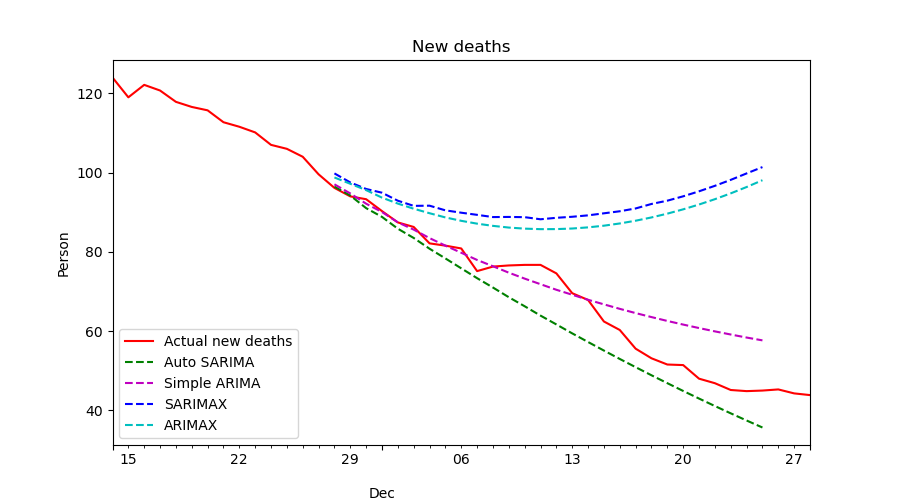

In [56]:
print('Prediction results for', prl, 'days followed by', train_len, 'days training samples:')
print('Auto SARIMA')
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, auto_arima_pr)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, auto_arima_pr)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, auto_arima_pr))))
print('Simple ARIMA')
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, arima_pr)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, arima_pr)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, arima_pr))))
srx_pr = srx_pr_df.values
print('SARIMAX')
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, srx_pr)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, srx_pr)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, srx_pr))))
arx_pr = arx_pr_df.values
print('ARIMAX')
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, arx_pr)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, arx_pr)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, arx_pr))))

fig, ax = plt.subplots(figsize=(9, 5))
ax.set(title='New deaths', xlabel='Date', ylabel='Person')
icf.iloc[train_len-14:train_len+prl + 3, 5].plot(ax=ax, style='r', label='Actual new deaths')
auto_arima_pr_df.plot(ax=ax, style='g--', label='Auto SARIMA')
arima_pr_df.plot(ax=ax, style='m--', label='Simple ARIMA')
srx_pr_df.plot(ax=ax, style='b--', label='SARIMAX')
arx_pr_df.plot(ax=ax, style='c--', label='ARIMAX')
legend = ax.legend(loc='lower left')

## Conclusion

In this part of the study, we used four models and compared the concept, implementation and the performance of the models. The ARIMA model with (p, d, q) parameters, can deliver good estimation of the studied values. Seasonality of the data was observed using seasonal_decompose. The Auto ARIMA using the pmdarima library conducts a search on the parameters. It also takes seasonality input and find the best model. In the SARIMAX model, we have used total_vaccination and stringency_index as exogenous data. And finally in ARIMAX, seasonality was ignored, and the total_vaccination and stringency_index were used as  exogenous data.

The performance of the models was investigated in some sections known as test data. The results does not show improvement of the models using exogenous features in SARIMAX model over SARIMA or ARIMA. Both of the exogenous features have long term effects on the studied values. This implies that the use of total_vaccination and stringency_index as exogenous data requires further investigation on how to use them. 